# Анализ данных сервиса для чтения книг по подписке

**Цель исследования** — сформулировать ценностное предложение для нового продукта.

**Заказчик исследования** — крупный сервис для чтения книг по подписке.

**Задача** — проанализировать информацию о книгах, издательствах, авторах, а также пользовательские обзоры книг в базе данных сервиса.

## 1. Описание данных

### 1.1 Таблицы в базе данных

Таблица **books** - содержит данные о книгах:
- `book_id` — идентификатор книги;
- `author_id` — идентификатор автора;
- `title` — название книги;
- `num_pages` — количество страниц;
- `publication_date` — дата публикации книги;
- `publisher_id` — идентификатор издателя.

Таблица **authors** - содержит данные об авторах:
- `author_id` — идентификатор автора;
- `author` — имя автора.

Таблица **publishers** - содержит данные об издательствах:
- `publisher_id` — идентификатор издательства;
- `publisher` — название издательства;

Таблица **ratings** - содержит данные о пользовательских оценках книг:
- `rating_id` — идентификатор оценки;
- `book_id` — идентификатор книги;
- `username` — имя пользователя, оставившего оценку;
- `rating` — оценка книги.

Таблица **reviews** - содержит данные о пользовательских обзорах на книги:
- `review_id` — идентификатор обзора;
- `book_id` — идентификатор книги;
- `username` — имя пользователя, написавшего обзор;
- `text` — текст обзора.


### 1.2 ER-диаграмма

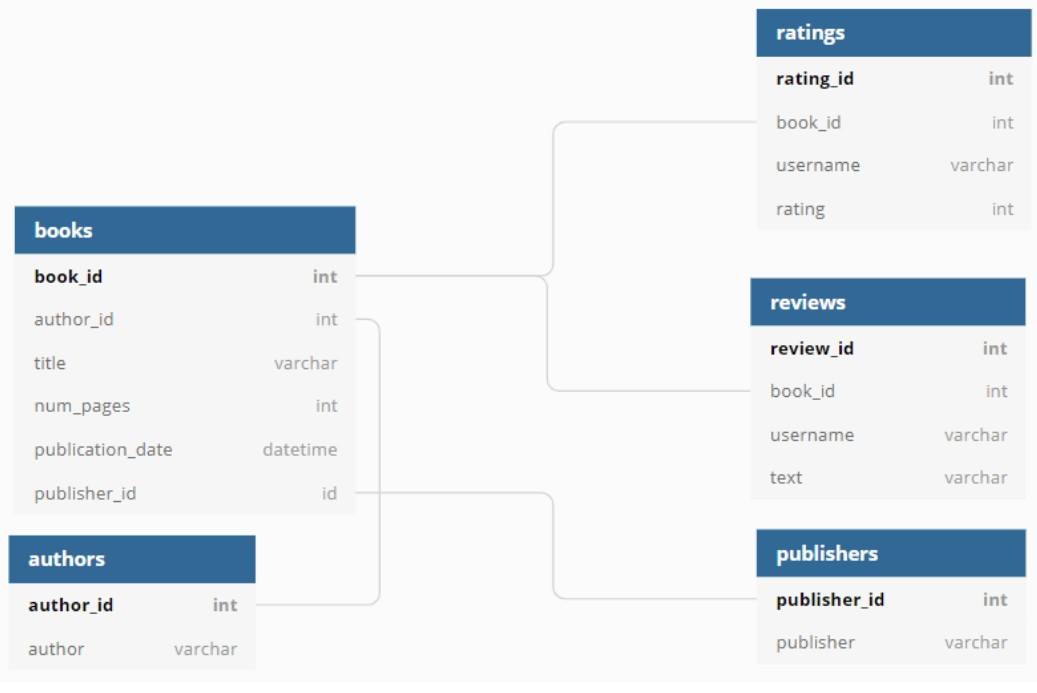

## 2. Исследование данных

In [1]:
import pandas as pd
from sqlalchemy import create_engine
import psycopg2

db_config = {
    'user': 'praktikum_student', # имя пользователя
    'pwd': 'Sdf4$2;d-d30pp', # пароль
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432, # порт подключения
    'db': 'data-analyst-final-project-db' # название базы данных
}
connection_string = 'postgresql://{user}:{pwd}@{host}:{port}/{db}'.format(**db_config)
engine = create_engine(connection_string, echo=False, connect_args={'sslmode':'require'})

### 2.1 Cколько книг вышло после 1 января 2000 года

Посчитаем, сколько книг вышло после 1 января 2000 года.

In [2]:
query = """
    select count(1) as books_count
    from books
    where publication_date > '2000-01-01'
"""
pd.read_sql(query, engine)

,books_count
0,819


**Вывод**

После 1 января 2000 года вышло 819 книг.

### 2.2 Количество обзоров и средняя оценка каждой книги

Для каждой книги посчитаем количество обзоров и среднюю оценку.

In [3]:
query = """
    select 
        books.book_id,
        books.title, 
        count(distinct reviews.review_id) as count_review,  
        avg(ratings.rating) as avg_ratings         
    from books
    left join ratings on ratings.book_id = books.book_id 
    left join reviews on reviews.book_id = books.book_id 
    group by books.book_id
    order by count_review desc, avg_ratings desc
"""
pd.read_sql(query, engine)

,book_id,title,count_review,avg_ratings
0,948,Twilight (Twilight #1),7,3.662500
1,302,Harry Potter and the Prisoner of Azkaban (Harr...,6,4.414634
2,299,Harry Potter and the Chamber of Secrets (Harry...,6,4.287500
3,656,The Book Thief,6,4.264151
4,734,The Glass Castle,6,4.206897
...,...,...,...,...
995,191,Disney's Beauty and the Beast (A Little Golden...,0,4.000000
996,387,Leonardo's Notebooks,0,4.000000
997,221,Essential Tales and Poems,0,4.000000
998,83,Anne Rice's The Vampire Lestat: A Graphic Novel,0,3.666667


**Вывод:** 

По выведенной информации можно выделить книги:
- с максимальным количеством просмотров, равным 7 - `Twilight (Twilight #1)`. Средняя оценка у нее 3,66.
- с минимальным количеством просмотров, равным 0 - `The Natural Way to Draw`, тем не менее средняя оценка у нее 3,00

### 2.3 Издательство с наибольшим количеством книг толще 50 страниц

Определим издательство, которое выпустило наибольшее число книг толще 50 страниц — так мы исключим из анализа брошюры.

In [4]:
query = """
    with publishers_50 as (
        select 
           b.book_id,
           p.publisher
        from books as b
        join publishers as p on b.publisher_id = p.publisher_id
        where b.num_pages > 50
    )
    select 
        publisher,
        count(book_id) as books_cnt
    from publishers_50
    group by publisher
    order by count(book_id) desc
    limit 1
"""
pd.read_sql(query, engine)

,publisher,books_cnt
0,Penguin Books,42


**Вывод**

По выведенной информации, мы видим, что издательство Penguin Books выпустило 42 книги толще 50 страниц.

### 2.4 Авторы с самой высокой средней оценкой книг

Определим автора с самой высокой средней оценкой книг. Учитывать будем только книги с 50 и более оценками.

In [5]:
query = """
    with book_ratings as (
        select 
            book_id,
            avg(rating) as avg_rating,
            count(rating) as total_ratings
        from ratings
        group by book_id
        having count(rating) >= 50
    ),
    author_average_ratings as (
        select 
            a.author_id,
            sum(br.total_ratings) as total_ratings,
            avg(br.avg_rating) as avg_rating
        from authors a
        join books b on a.author_id = b.author_id
        join book_ratings br on b.book_id = br.book_id
        group by a.author_id
    )
    select 
        a.author,
        aar.total_ratings,
        aar.avg_rating
    from authors a
    join author_average_ratings aar on a.author_id = aar.author_id
    order by aar.avg_rating desc
    limit 1
"""
pd.read_sql(query, engine)

,author,total_ratings,avg_rating
0,J.K. Rowling/Mary GrandPré,310.0,4.283844


**Вывод**

Автором с самой высокой средней оценкой книг является - J.K. Rowling. Средняя оценка - 4,28

### 2.5 Cреднее количество обзоров

Посчитаем среднее количество обзоров от пользователей, которые поставили больше 48 оценок.

In [6]:
query = """
    with user_ratings as (
        select 
            username,
            count(rating_id) as ratings_count
        from ratings
        group by username
        having count(rating_id) > 48
    ),
    user_reviews as (
        select 
            username,
            count(review_id) as reviews_count
        from reviews
        where username in (select username from user_ratings)
        group by username
    )
    select 
        round(avg(reviews_count), 2) as average_reviews
    from user_reviews
"""
pd.read_sql(query, engine)

,average_reviews
0,24.0


**Вывод**

Среднее количество обзоров от пользователей, которые поставили больше 48 оценок, равно 24.

### 3. Общие выводы

В ходе работы мы проанализировали базу данных крупного сервиса для чтения книг. 

По результатам проделанной работы получили следующие выводы:
1. После 1 января 2000 года было выпущено 819 книг.
2. Выделили книги:    
    - с максимальным количеством просмотров, равным 7 - `Twilight (Twilight #1)`, cредняя оценка у нее 3,66.    
    - с минимальным количеством просмотров, равным 0 - `The Natural Way to Draw`, средняя оценка у нее 3,00.
3. Издательство `Penguin Books` выпустило 42 книги толще 50 страниц.
4. Автором с самой высокой средней оценкой книг является - `J.K. Rowling`. Средняя оценка - 4,28.
5. Среднее количество обзоров от пользователей, которые поставили больше 48 оценок, равно 24.